In [1]:
from pathlib import Path
import math
import csv

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
def precision_at_k(q_predicted_ranking, q_gold_ranking, k):
    k = min(k, len(q_predicted_ranking))
    q_predicted_ranking = q_predicted_ranking[:k]
    number_of_hits = sum([predicted_doc in q_gold_ranking for predicted_doc in q_predicted_ranking])
    return number_of_hits/k

def recall_at_k(q_predicted_ranking, q_gold_ranking, k):
    k = min(k, len(q_predicted_ranking))
    q_predicted_ranking = q_predicted_ranking[:k]
    number_of_hits = sum([predicted_doc in q_gold_ranking for predicted_doc in q_predicted_ranking])
    number_of_relevant_docs = len(q_gold_ranking)
    return number_of_hits/number_of_relevant_docs

def resultados_query_parser(query_results_string):
    # ['doc_num_rank1', 'doc_num_rank2', ...]
    query_results_list = eval(query_results_string)
    q_docs_ranking = [result_tuple[1] for result_tuple in query_results_list]
    return q_docs_ranking

def resultados_parser(resultados_file):
    results_dict = {}
    with open(resultados_file, mode='r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        for row in csv_reader:
            query_number = row[0]
            query_results_string = row[1]
            results_dict[query_number] = resultados_query_parser(query_results_string)
    return results_dict

def esperados_parser(esperados_file):
    esperados_dict = {}
    with open(esperados_file, mode='r') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        first_row = True
        for row in csv_reader:
            if first_row is False:
                query_number = row[0]
                doc_number = row[1]
                if query_number in esperados_dict:
                    esperados_dict[query_number].append(doc_number)
                else:
                    esperados_dict[query_number] = [doc_number]
            else:
                first_row = False
    return esperados_dict

def argmax(x):
    return max(range(len(x)), key=lambda i: x[i])

def get_index(m_list, value):
    for i, v in enumerate(m_list):
        if v >= value:
            return i



In [36]:

resultados_stemmer = resultados_parser('../RESULT/RESULTADOS-STEMMER.csv')
resultados_nostemmer = resultados_parser('../RESULT/RESULTADOS-NOSTEMMER.csv')
esperados = esperados_parser('../RESULT/esperados.csv')


In [29]:
resultados = resultados_parser('../RESULT/RESULTADOS.csv')

In [31]:
resultados = {'00001': ['d1', 'd6', 'd5', 'd7', 'd2', 'd9', 'd4', 'd10', 'd3'],
              '00002': ['d1', 'd10', 'd3']}

esperados = {'00001': ['d1', 'd2', 'd3', 'd4', 'd5'],
             '00002': ['d1', 'd2', 'd3']}

## 11 Pontos

In [5]:
def get_precisions(consulta, resultados):
    ranking_size = len(resultados[consulta])
    precisions = []
    for k in range(1, ranking_size + 1):
        precisions.append(precision_at_k(q_predicted_ranking=resultados[consulta], q_gold_ranking=esperados[consulta], k=k))
    return precisions

def get_recalls(consulta, resultados):
    ranking_size = len(resultados[consulta])
    recalls = []
    for k in range(1, ranking_size + 1):
        recalls.append(recall_at_k(q_predicted_ranking=resultados[consulta], q_gold_ranking=esperados[consulta], k=k))
    return recalls

def precisao_interpolada(consulta, resultados, percent=False):
    precisions = get_precisions(consulta, resultados)
    recalls = get_recalls(consulta, resultados)

    recall_points = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    
    precision_points = []
    for point in recall_points:
        point_index = get_index(recalls, point)
        prec_point = max(precisions[point_index:]) if point_index is not None else 0
        precision_points.append(prec_point)
    if percent:
        return np.round(np.array(precision_points)*100, 0)
    
    return precision_points

def prec_rec_11(resultados, prec=0, percent=False):
    
    prec_points_consultas = []
    for consulta in esperados.keys():
        prec_points_consultas.append(precisao_interpolada(consulta, resultados, percent=percent))

    mult = 1 if percent else 100

    return np.round(np.mean(np.array(prec_points_consultas)*mult, axis=0), prec)

In [6]:
prec_interpolada_media_nostemmer = prec_rec_11(resultados_nostemmer, percent=True)
prec_interpolada_media_stemmer = prec_rec_11(resultados_stemmer, percent=True)

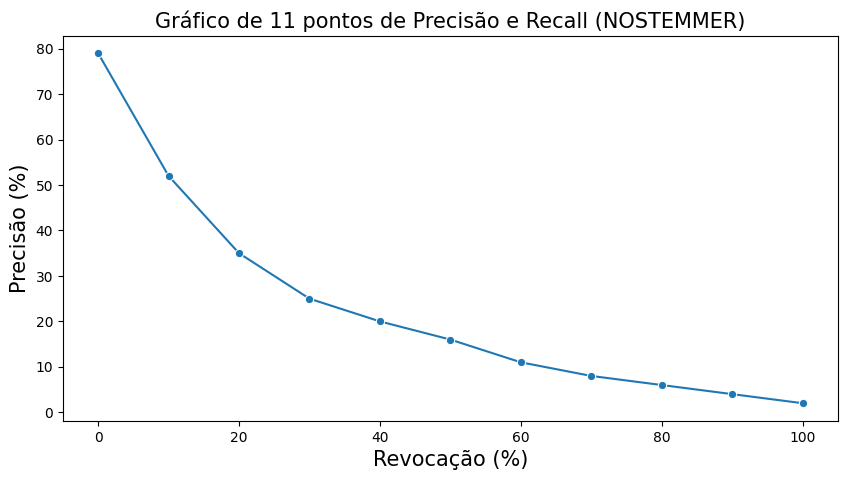

In [7]:
fig, ax = plt.subplots(figsize=(10,5))

x = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
y = prec_interpolada_media_nostemmer

sns.lineplot(x=x, y=y, ax=ax, marker="o")
ax.set_xlabel('Revocação (%)', fontsize=15)
ax.set_ylabel('Precisão (%)', fontsize=15)
ax.set_title('Gráfico de 11 pontos de Precisão e Recall (NOSTEMMER)', fontsize=15)

plt.show()

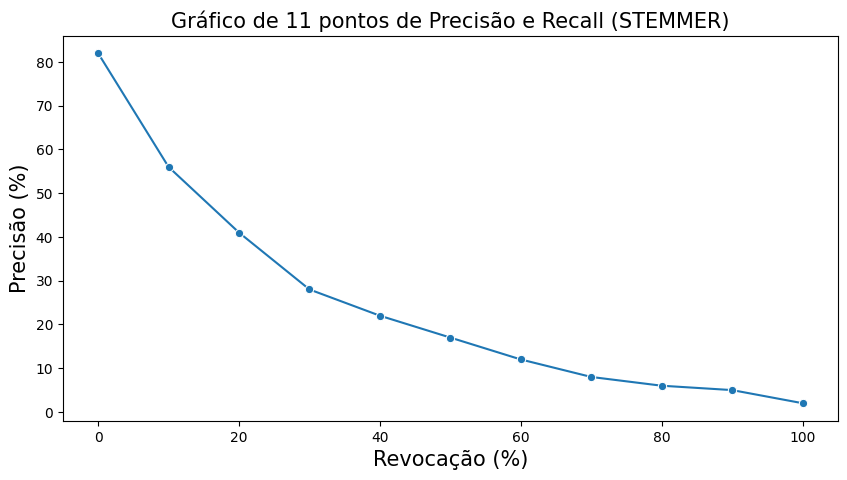

In [8]:
fig, ax = plt.subplots(figsize=(10,5))

x = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
y = prec_interpolada_media_stemmer

sns.lineplot(x=x, y=y, ax=ax, marker="o")
ax.set_xlabel('Revocação (%)', fontsize=15)
ax.set_ylabel('Precisão (%)', fontsize=15)
ax.set_title('Gráfico de 11 pontos de Precisão e Recall (STEMMER)', fontsize=15)

plt.show()

In [19]:
df_11_nostemmer = pd.DataFrame.from_dict({'Recall': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'Precision': prec_interpolada_media_nostemmer})
df_11_stemmer = pd.DataFrame.from_dict({'Recall': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'Precision': prec_interpolada_media_stemmer})

df_11_nostemmer.to_csv('../AVALIA/11pontos-nostemmer-1.csv', index=False)
df_11_stemmer.to_csv('../AVALIA/11pontos-stemmer-1.csv', index=False)

## F1

In [57]:
def f1_at_k(q_predicted_ranking, q_gold_ranking, k):
    precision = precision_at_k(q_predicted_ranking, q_gold_ranking, k)
    recall = recall_at_k(q_predicted_ranking, q_gold_ranking, k)
    #print(f'Precision: {precision}\nRecall: {recall}')
    if precision == 0 and recall == 0:
        return 0
    f1_score = (2*precision*recall)/(precision+recall)
    return f1_score

def media_f1_at_k(k, resultados):
    f1s_at_k = []
    for consulta in esperados.keys():
        f1s_at_k.append(f1_at_k(resultados[consulta], esperados[consulta], k=k))
    return np.mean(f1s_at_k)

def media_f1(consulta, resultados):
    precisions = np.array(get_precisions(consulta, resultados))
    recalls = np.array(get_recalls(consulta, resultados))

    a = 2*precisions*recalls
    b = precisions+recalls
    f1_score_array = np.divide(a,b, out=np.zeros_like(a), where= b!= 0)
    #f1_score_array = (2*precisions*recalls)/(precisions+recalls)
    return np.mean(f1_score_array)

def media_media_f1(resultados):
    medias_f1 = []
    for consulta in esperados.keys():
        medias_f1.append(media_f1(consulta, resultados))
    return np.mean(medias_f1)    

In [59]:
print(f'Média entre consultas f1@10 (nostemmer): {round(media_f1_at_k(k=10, resultados=resultados_nostemmer), 2)}')
print(f'Média das médias entre consultas de f1 (nostemmer): {round(media_media_f1(resultados_nostemmer), 2)}')

Média entre consultas f1@10 (nostemmer): 0.18
Média das médias entre consultas de f1 (nostemmer): 0.11


In [60]:
print(f'Média entre consultas f1@10 (stemmer): {round(media_f1_at_k(k=10, resultados=resultados_stemmer), 2)}')
print(f'Média das médias entre consultas de f1 (stemmer): {round(media_media_f1(resultados_stemmer), 2)}')

Média entre consultas f1@10 (stemmer): 0.19
Média das médias entre consultas de f1 (stemmer): 0.11


## Precision@5 e Precision@10

In [61]:
def media_precision_at_k(k, resultados):
    precisions_at_k = []
    for consulta in esperados.keys():
        precisions_at_k.append(precision_at_k(resultados[consulta], esperados[consulta], k=k))
    return np.mean(precisions_at_k)

In [62]:
print(f'Média entre consultas Precision@5 (nostemmer): {round(media_precision_at_k(k=5, resultados=resultados_nostemmer), 2)}')
print(f'Média entre consultas Precision@10 (nostemmer): {round(media_precision_at_k(k=10, resultados=resultados_nostemmer), 2)}')

Média entre consultas Precision@5 (nostemmer): 0.47
Média entre consultas Precision@10 (nostemmer): 0.39


In [63]:
print(f'Média entre consultas Precision@5 (stemmer): {round(media_precision_at_k(k=5, resultados=resultados_stemmer), 2)}')
print(f'Média entre consultas Precision@10 (stemmer): {round(media_precision_at_k(k=10, resultados=resultados_stemmer), 2)}')

Média entre consultas Precision@5 (stemmer): 0.51
Média entre consultas Precision@10 (stemmer): 0.42


## Histograma de R-Precision (comparativo)

In [67]:
def r_precision(consulta, resultados):
    r = len(esperados[consulta])
    return precision_at_k(resultados[consulta], esperados[consulta], k=r)

def r_precision_consultas(resultados):
    r_precisions = []
    for consulta in esperados.keys():
        r_precisions.append(r_precision(consulta, resultados))
    return np.array(r_precisions)

def r_precision_hist(resultados_nostemmer, resultados_stemmer):
    r_precisions_nostemmer = r_precision_consultas(resultados_nostemmer)
    r_precisions_stemmer = r_precision_consultas(resultados_stemmer)
    rp = r_precisions_nostemmer - r_precisions_stemmer
    return rp



In [68]:
rp = r_precision_hist(resultados_nostemmer, resultados_stemmer)

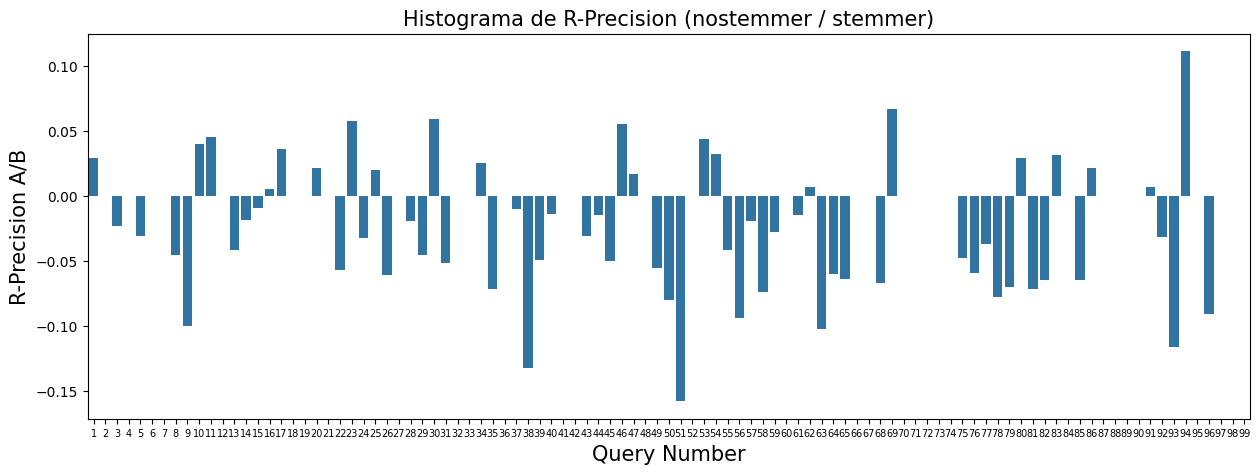

In [89]:
fig, ax = plt.subplots(figsize=(15,5))

x = list(range(1, len(rp)+1))
y = rp

sns.barplot(x=x, y=y, ax=ax)
ax.set_xlabel('Query Number', fontsize=15)
ax.tick_params(axis='x', labelsize=7, labelrotation=0)
ax.set_ylabel('R-Precision A/B', fontsize=15)
ax.set_title('Histograma de R-Precision (nostemmer / stemmer)', fontsize=15)

plt.show()

In [111]:
df_rprecision = pd.DataFrame.from_dict({'QueryNumber': list(range(1, len(rp)+1)), 'RPrecisionAB': rp})
df_rprecision.to_csv('../AVALIA/rprecision-histograma.csv', index=False)

## MAP

In [94]:
def average_precision(consulta, resultados):
    consulta_resultados = resultados[consulta]
    consulta_esperados = esperados[consulta]
    num_esperados = len(consulta_esperados)
    precisions_at_k = []
    for i, res in enumerate(consulta_resultados, 1):
        if res in consulta_esperados:
            precisions_at_k.append(precision_at_k(consulta_resultados, consulta_esperados, k=i))
    average_precision_score = np.sum(precisions_at_k)/num_esperados
    return average_precision_score

def MAP(resultados):
    avgs = []
    for consulta in esperados.keys():
        avgs.append(average_precision(consulta, resultados))
    return np.mean(avgs)

In [106]:
print(f'MAP nostemmer: {round(MAP(resultados_nostemmer), 2)}')
print(f'MAP stemmer: {round(MAP(resultados_stemmer), 2)}')

MAP nostemmer: 0.21
MAP stemmer: 0.23


## MRR

In [97]:
def RR(consulta, resultados):
    consulta_resultados = resultados[consulta]
    consulta_esperados = esperados[consulta]

    for i, res in enumerate(consulta_resultados, 1):
        if res in consulta_esperados:
            return 1/i
    return 0

def MRR(resultados):
    rrs = []
    for consulta in esperados.keys():
        rrs.append(RR(consulta, resultados))
    return np.mean(rrs)

In [105]:
print(f'MRR nostemmer: {round(MRR(resultados_nostemmer), 2)}')
print(f'MRR stemmer: {round(MRR(resultados_stemmer), 2)}')

MRR nostemmer: 0.77
MRR stemmer: 0.78


## DCG e NDCG

In [101]:
df_esperados = pd.read_csv('../RESULT/esperados.csv', delimiter=';')
df_esperados['DocNumber'] = df_esperados['DocNumber'].astype(str)

In [103]:
def gain(rel, i):
    if i == 1:
        return rel
    return rel / math.log2(i)

def DCG(consulta, resultados):
    consulta_resultados = resultados[consulta]
    consulta_esperados = df_esperados[df_esperados['QueryNumber'] == int(consulta)][['DocNumber', 'DocVotes']]

    dcg = 0
    for i, res in enumerate(consulta_resultados, 1):
        rel = 0
        if res in consulta_esperados['DocNumber'].values:
            rel = consulta_esperados[consulta_esperados['DocNumber'] == res]['DocVotes'].values[0]
        dcg += gain(rel, i)
    return dcg

def media_DCG(resultados):
    dcgs = []
    for consulta in esperados.keys():
        dcgs.append(DCG(consulta, resultados))
    return np.mean(dcgs)


def NORM(consulta):
    votes = df_esperados[df_esperados['QueryNumber'] == int(consulta)]['DocVotes'].sort_values(ascending=False).to_list()
    norm = 0
    for i, vote in enumerate(votes, 1):
        norm += gain(vote, i)
    return norm

def NDCG(consulta, resultados):
    dcg = DCG(consulta, resultados)
    norm = NORM(consulta)
    return dcg/norm

def media_NDCG(resultados):
    ndcgs = []
    for consulta in esperados.keys():
        ndcgs.append(NDCG(consulta, resultados))
    return np.mean(ndcgs)

In [107]:
print(f'DCG nostemmer: {round(media_DCG(resultados_nostemmer), 2)}')
print(f'DCG stemmer: {round(media_DCG(resultados_stemmer), 2)}')

DCG nostemmer: 28.74
DCG stemmer: 30.27


In [108]:
print(f'NDCG nostemmer: {round(media_NDCG(resultados_nostemmer), 2)}')
print(f'NDCG stemmer: {round(media_NDCG(resultados_stemmer), 2)}')

NDCG nostemmer: 0.54
NDCG stemmer: 0.57
